<a href="https://colab.research.google.com/github/SidLuca/Event-Type-Classification/blob/main/hepbell2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dataset...
Initial shape: (70606, 61)
Event type counts:
 mc_label
bbbar    35765
ccbar    23333
uubar     8172
ddbar     1879
ssbar     1457
Name: count, dtype: int64
Final feature count after cleaning: 50
Train/Test shapes: (52954, 50) (17652, 50)
Estimating feature importances with RandomForest...
Top 12 features:
 ['R2', 'thrustOm', 'KSFWVariables__bohoo2__bc', 'thrust', 'cosTBTO', 'CleoConeCS__bo1__bc', 'foxWolframR2', 'KSFWVariables__bohso02__bc', 'KSFWVariables__bohso02__cmFS1__bc', 'thrustBm', 'KSFWVariables__bohso12__bc', 'KSFWVariables__bohso12__cmFS1__bc']


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Classification report:
               precision    recall  f1-score   support

       bbbar       0.79      0.90      0.84      8942
       ccbar       0.61      0.71      0.65      5833
       ddbar       0.00      0.00      0.00       470
       ssbar       0.00      0.00      0.00       364
       uubar       0.41      0.12      0.19      2043

    accuracy                           0.70     17652
   macro avg       0.36      0.35      0.34     17652
weighted avg       0.65      0.70      0.66     17652

Confusion matrix:
 [[8008  899    0    0   35]
 [1457 4157    0    0  219]
 [ 124  294    0    0   52]
 [  90  230    0    0   44]
 [ 517 1281    0    0  245]]
PCA components for 95% variance: 7


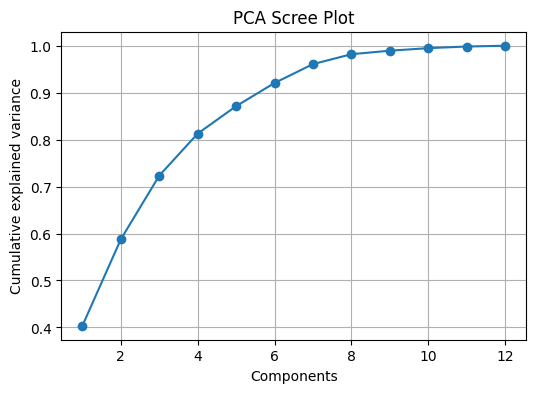

In [ ]:
# Install dependencies if missing
# !pip install pandas numpy scikit-learn matplotlib joblib

import os, joblib
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

# --------------------------
# CONFIG
# --------------------------
CSV_PATH = "data_hep - data_hep.csv"   # use the exact name in your Colab sidebar
TOP_N_FEATURES = 12
RANDOM_STATE = 42

# --------------------------
# 1. Load data
# --------------------------
print("Loading dataset...")
df = pd.read_csv(CSV_PATH)
print("Initial shape:", df.shape)

# Drop bookkeeping column if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Map event type to labels
def map_type(t):
    if t in (0,1): return "bbbar"
    return {2:"ccbar", 3:"uubar", 4:"ddbar", 5:"ssbar"}.get(t, "other")

df["mc_label"] = df["type"].map(map_type)
print("Event type counts:\n", df["mc_label"].value_counts())

# --------------------------
# 2. Clean features
# --------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constant features
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [c for c in features if c not in const_cols]

# Drop very low variance features
variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# Correlation pruning
corr = df[features].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.98)]
df = df.drop(columns=to_drop)
features = [f for f in features if f not in to_drop]

print("Final feature count after cleaning:", len(features))

# --------------------------
# 3. Prepare data
# --------------------------
X = df[features].fillna(0).values
y = df["mc_label"].values
le = LabelEncoder()
y_enc = le.fit_transform(y)

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=RANDOM_STATE
)
print("Train/Test shapes:", Xtr.shape, Xte.shape)

# --------------------------
# 4. Feature importance (RandomForest)
# --------------------------
print("Estimating feature importances with RandomForest...")
rf = RandomForestClassifier(
    n_estimators=150, max_depth=7, random_state=RANDOM_STATE, n_jobs=-1
)
rf.fit(Xtr, ytr)

feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
topN = feat_imp.head(TOP_N_FEATURES).index.tolist()
print(f"Top {TOP_N_FEATURES} features:\n", topN)

# --------------------------
# 5. Train reduced model (Logistic Regression)
# --------------------------
Xtr_red = Xtr[:, [features.index(f) for f in topN]]
Xte_red = Xte[:, [features.index(f) for f in topN]]

scaler = StandardScaler().fit(Xtr_red)
Xtr_red_s = scaler.transform(Xtr_red)
Xte_red_s = scaler.transform(Xte_red)

lr = LogisticRegression(
    max_iter=500, multi_class="multinomial", solver="saga", random_state=RANDOM_STATE, n_jobs=-1
)
lr.fit(Xtr_red_s, ytr)

ypred = lr.predict(Xte_red_s)

print("\nClassification report:\n", classification_report(yte, ypred, target_names=le.classes_, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(yte, ypred))

# --------------------------
# 6. PCA on reduced features
# --------------------------
pca = PCA().fit(Xtr_red_s)
cumvar = np.cumsum(pca.explained_variance_ratio_)
n95 = int(np.searchsorted(cumvar, 0.95) + 1)
print("PCA components for 95% variance:", n95)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cumvar)+1), cumvar, marker="o")
plt.xlabel("Components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()


Binary_classification

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("hep.csv")

# Drop bookkeeping col
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Map event type -> binary class
def map_binary(t):
    if t in (0,1): return "BB"          # Signal
    else: return "continuum"            # Background

df["binary_label"] = df["type"].map(map_binary)

print("Event counts:\n", df["binary_label"].value_counts())

# --------------------------
# Clean features
# --------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constants
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [c for c in features if c not in const_cols]

# Drop low variance
variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# Correlation pruning
corr = df[features].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.98)]
df = df.drop(columns=to_drop)
features = [f for f in features if f not in to_drop]

print("Final features:", len(features))

# --------------------------
# Prepare data
# --------------------------
X = df[features].fillna(0).values
y = df["binary_label"].values

le = LabelEncoder()
y_enc = le.fit_transform(y)   # 0 = BB, 1 = continuum (or vice versa)

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

# --------------------------
# Feature importance
# --------------------------
rf = RandomForestClassifier(n_estimators=150, max_depth=7, random_state=42, n_jobs=-1)
rf.fit(Xtr, ytr)

feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
topN = feat_imp.head(12).index.tolist()
print("Top 12 features:", topN)

# --------------------------
# Train reduced Logistic Regression
# --------------------------
Xtr_red = Xtr[:, [features.index(f) for f in topN]]
Xte_red = Xte[:, [features.index(f) for f in topN]]

scaler = StandardScaler().fit(Xtr_red)
Xtr_red_s = scaler.transform(Xtr_red)
Xte_red_s = scaler.transform(Xte_red)

lr = LogisticRegression(max_iter=500, solver="saga", random_state=42)
lr.fit(Xtr_red_s, ytr)

ypred = lr.predict(Xte_red_s)

print("\nClassification Report:\n", classification_report(yte, ypred, target_names=le.classes_, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(yte, ypred))

# --------------------------
# PCA Scree Plot
# --------------------------
pca = PCA().fit(Xtr_red_s)
cumvar = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cumvar)+1), cumvar, marker="o")
plt.xlabel("Components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Scree Plot (Binary Classification)")
plt.grid(True)
plt.show()
# --------------------------
# Confusion Matrix Plot
# --------------------------
cm = confusion_matrix(yte, ypred)
labels = le.classes_  # ['BB', 'continuum']

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    ylabel="True label",
    xlabel="Predicted label",
    title="Confusion Matrix"
)

# Rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add numbers on boxes
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()




FileNotFoundError: [Errno 2] No such file or directory: 'hep.csv'

Same with others

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("data_hep - data_hep.csv")

# Drop bookkeeping col
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Map event type -> binary class
def map_binary(t):
    if t in (0,1):
        return "BB"          # Signal
    else:
        return "continuum"   # Background

df["binary_label"] = df["type"].map(map_binary)
print("Event counts:\n", df["binary_label"].value_counts())

# --------------------------
# Prepare features
# --------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constants
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [f for f in features if f not in const_cols]

# Drop low variance
variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# --------------------------
# Train/test split
# --------------------------
X = df[features].fillna(0).values
y = df["binary_label"].values

le = LabelEncoder()
y_enc = le.fit_transform(y)  # 0 = BB, 1 = continuum

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

# --------------------------
# Scale features
# --------------------------
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr)
Xte_s = scaler.transform(Xte)

# --------------------------
# 1. Random Forest
# --------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,        # Let trees grow fully
    min_samples_leaf=5,    # Prevent overfitting
    random_state=42,
    n_jobs=-1
)
rf.fit(Xtr_s, ytr)
ypred_rf = rf.predict(Xte_s)

print("\n=== Random Forest ===")
print(classification_report(yte, ypred_rf, target_names=le.classes_, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(yte, ypred_rf))

# --------------------------
# 2. Gradient Boosting (XGBoost)
# --------------------------
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(Xtr_s, ytr)
ypred_xgb = xgb_model.predict(Xte_s)

print("\n=== XGBoost ===")
print(classification_report(yte, ypred_xgb, target_names=le.classes_, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(yte, ypred_xgb))

# --------------------------
# Optional: Feature importance from Random Forest
# --------------------------
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
top_features = importances.head(15)
print("\nTop 15 features from RF:\n", top_features)
top_features.plot(kind='bar', figsize=(10,4), title='Random Forest Feature Importance')
plt.show()
import matplotlib.pyplot as plt
import pandas as pd

# --------------------------
# XGBoost feature importance
# --------------------------
xgb_importances = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)

# Top 15 features
top_xgb = xgb_importances.head(15)
print("Top 15 XGBoost features:\n", top_xgb)

# Plot
plt.figure(figsize=(10,5))
top_xgb.plot(kind='bar', title='XGBoost Feature Importance')
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Optional: XGBoost built-in plot
from xgboost import plot_importance

plt.figure(figsize=(10,6))
plot_importance(xgb_model, max_num_features=15, height=0.6)
plt.title("XGBoost Feature Importance (built-in)")
plt.show()



diffrents_models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Tree-based models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("data_hep - data_hep.csv")

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Binary mapping
def map_binary(t):
    if t in (0,1):
        return "BB"
    else:
        return "continuum"

df["binary_label"] = df["type"].map(map_binary)
print("Event counts:\n", df["binary_label"].value_counts())

# Features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constants and low variance
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [f for f in features if f not in const_cols]

variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# --------------------------
# Train/test split
# --------------------------
X = df[features].fillna(0).values
y = df["binary_label"].values

le = LabelEncoder()
y_enc = le.fit_transform(y)  # 0 = BB, 1 = continuum

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

# Scale features
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr)
Xte_s = scaler.transform(Xte)

# --------------------------
# Models dictionary
# --------------------------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=5, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
                                 use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42)
}

# --------------------------
# Train, predict, evaluate
# --------------------------
results = {}

for name, model in models.items():
    model.fit(Xtr_s, ytr)
    ypred = model.predict(Xte_s)

    print(f"\n=== {name} ===")
    print(classification_report(yte, ypred, target_names=le.classes_, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(yte, ypred))

    results[name] = {
        "accuracy": (ypred == yte).mean(),
        "f1_score": classification_report(yte, ypred, output_dict=True)["macro avg"]["f1-score"]
    }

# --------------------------
# Compare accuracies and F1
# --------------------------
results_df = pd.DataFrame(results).T
print("\nModel comparison:\n", results_df)

# Plot comparison
plt.figure(figsize=(6,4))
results_df[["accuracy","f1_score"]].plot(kind='bar', rot=0)
plt.title("Binary Classification: Model Comparison")
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


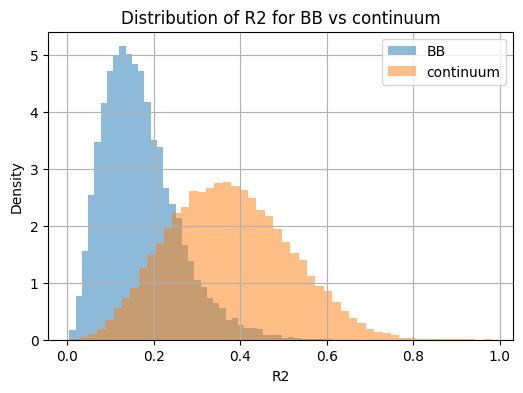

In [ ]:
# -------------------------
# Plot one feature for BB vs continuum
# -------------------------
import matplotlib.pyplot as plt

feature = "R2"   # replace with any numeric feature you want

plt.figure(figsize=(6,4))

# Plot histogram for BB
bb_data = df[df["binary_label"]=="BB"][feature].dropna()
plt.hist(bb_data, bins=50, density=True, alpha=0.5, label="BB", color="C0")

# Plot histogram for continuum
cont_data = df[df["binary_label"]=="continuum"][feature].dropna()
plt.hist(cont_data, bins=50, density=True, alpha=0.5, label="continuum", color="C1")

plt.xlabel(feature)
plt.ylabel("Density")
plt.title(f"Distribution of {feature} for BB vs continuum")
plt.legend()
plt.grid(True)
plt.show()


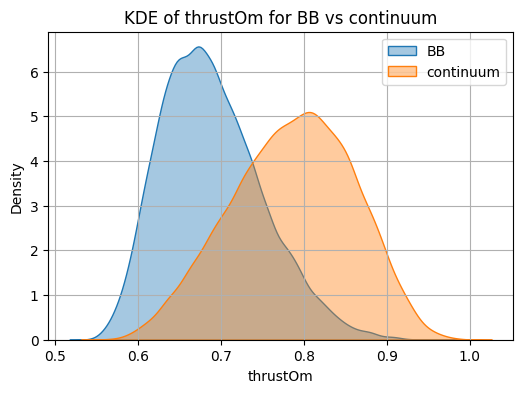

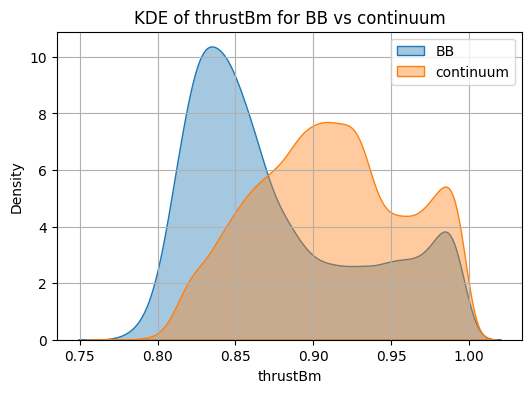

In [ ]:
# -------------------------
# KDE plot for thrustOm and thrustBm
# -------------------------
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = ["thrustOm", "thrustBm"]

for feature in features_to_plot:
    plt.figure(figsize=(6,4))

    # KDE for BB
    bb_data = df[df["binary_label"]=="BB"][feature].dropna()
    sns.kdeplot(bb_data, label="BB", color="C0", fill=True, alpha=0.4)

    # KDE for continuum
    cont_data = df[df["binary_label"]=="continuum"][feature].dropna()
    sns.kdeplot(cont_data, label="continuum", color="C1", fill=True, alpha=0.4)

    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.title(f"KDE of {feature} for BB vs continuum")
    plt.legend()
    plt.grid(True)
    plt.show()


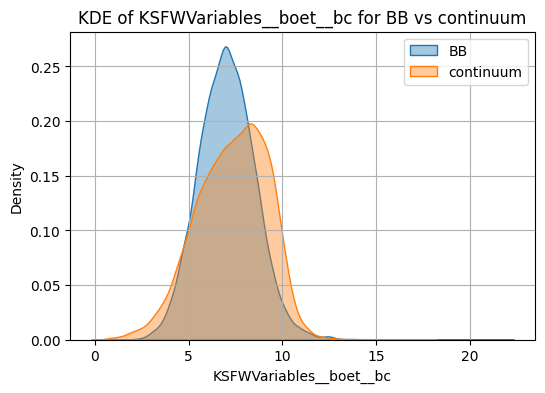

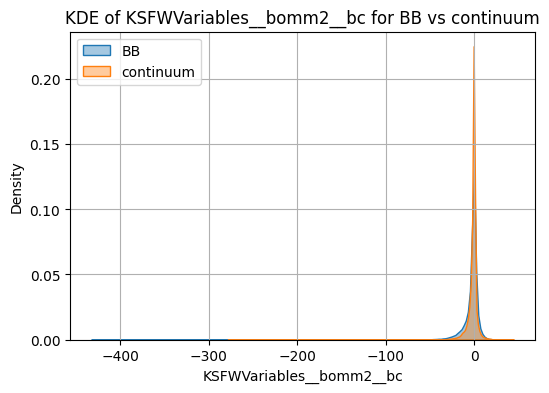

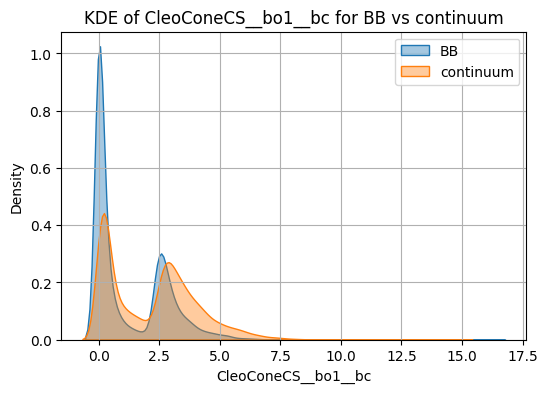

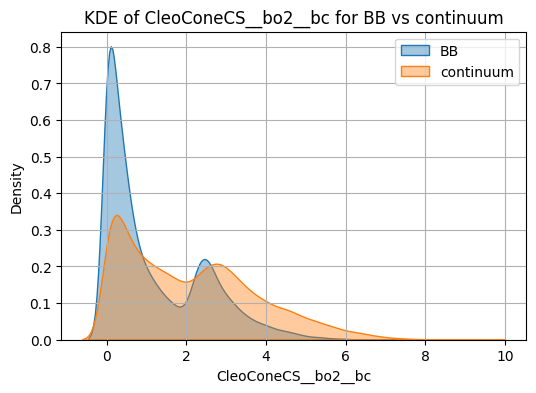

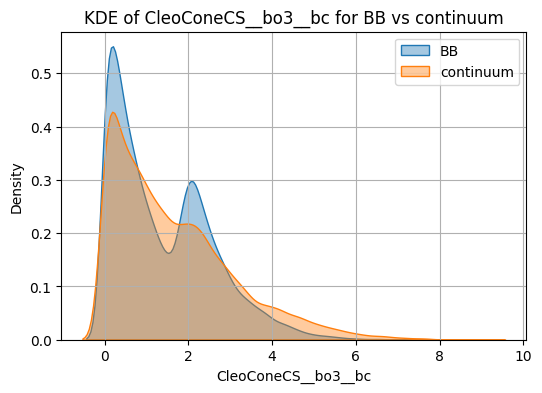

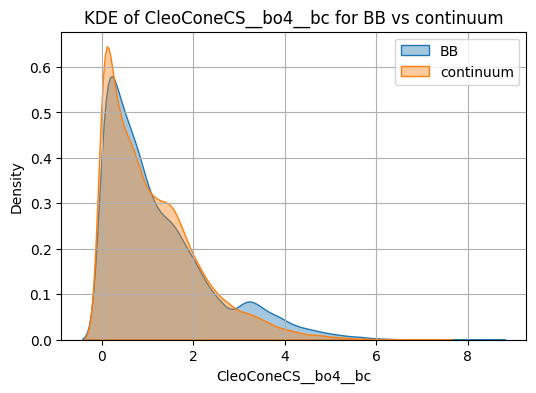

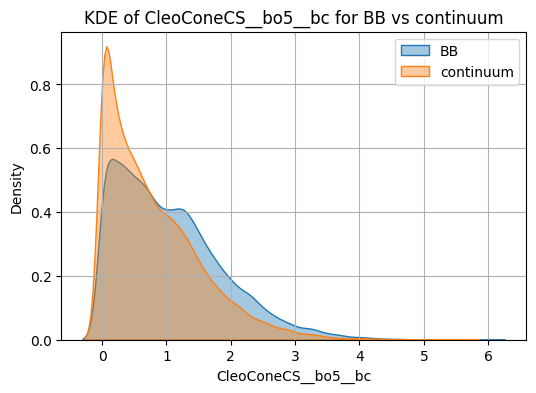

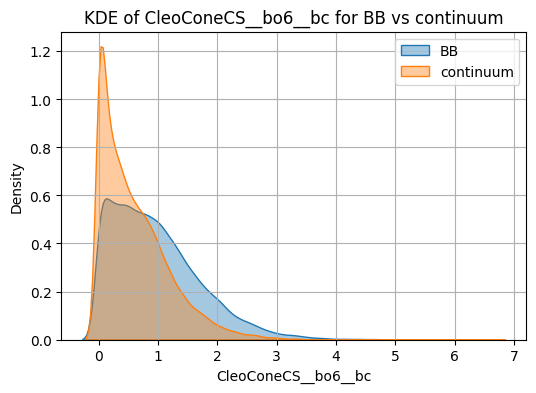

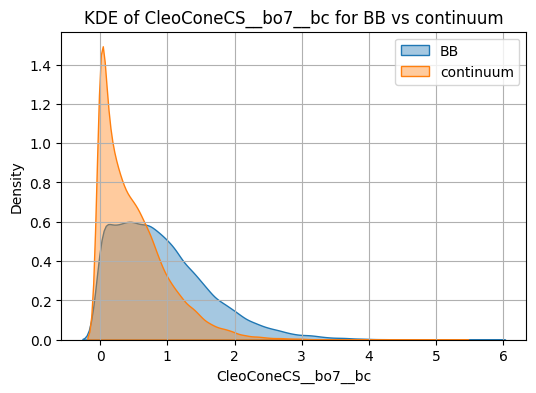

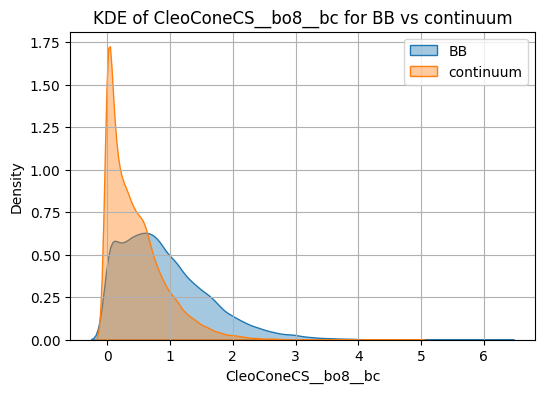

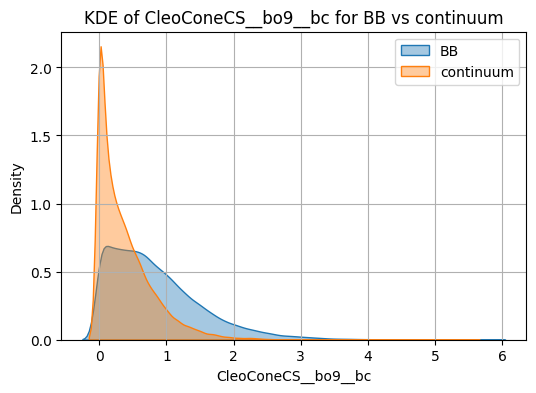

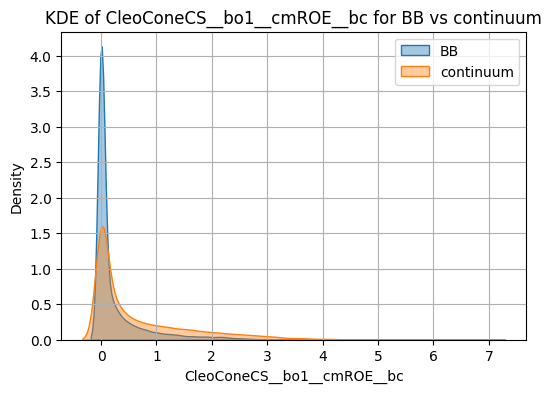

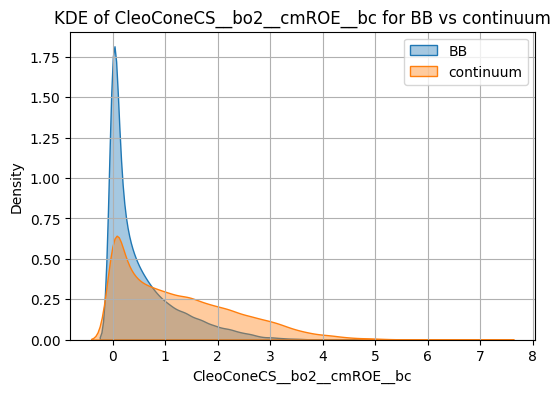

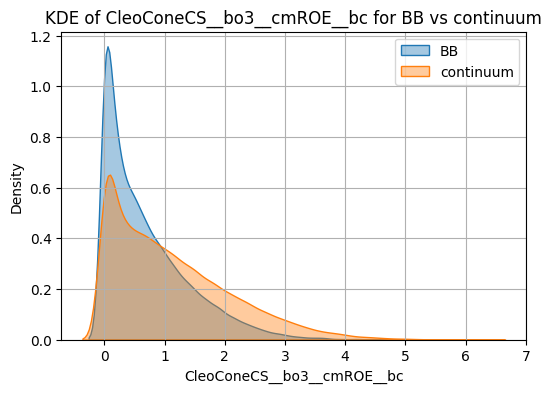

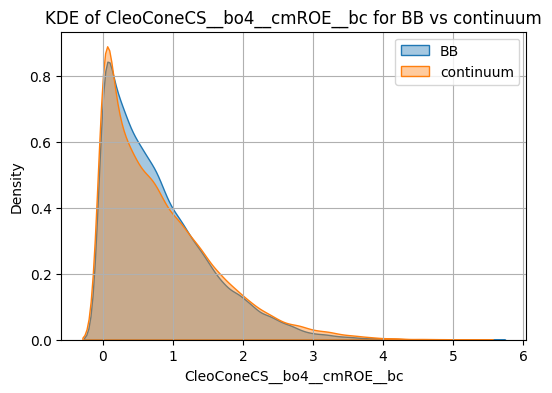

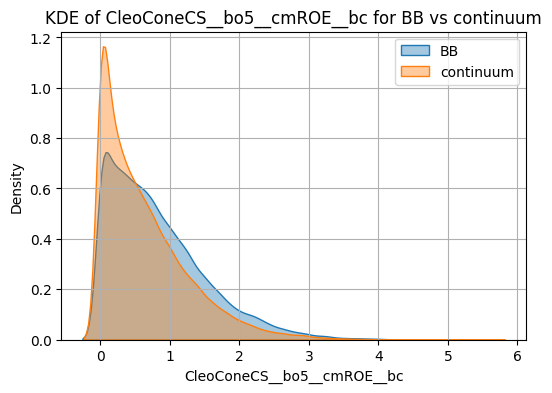

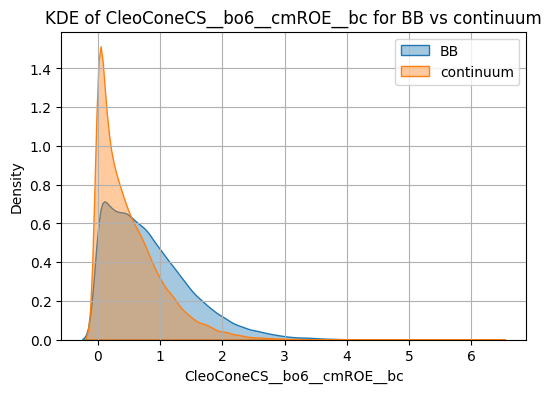

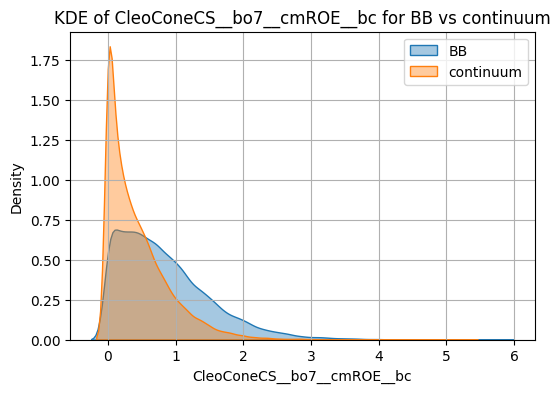

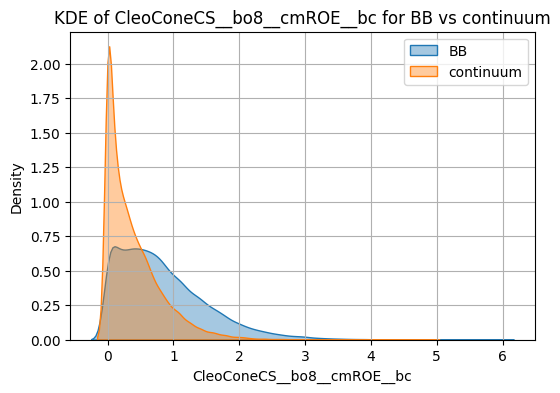

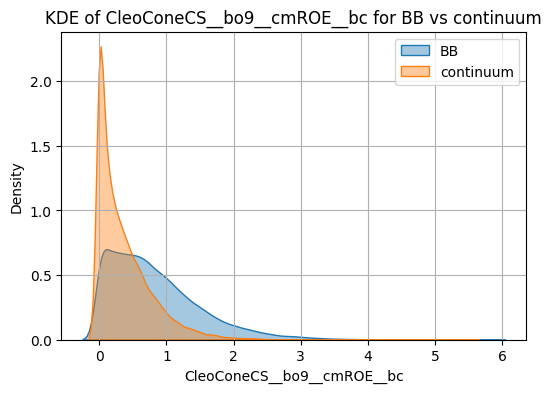

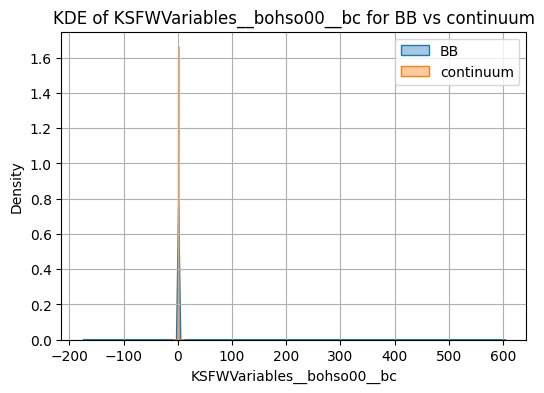

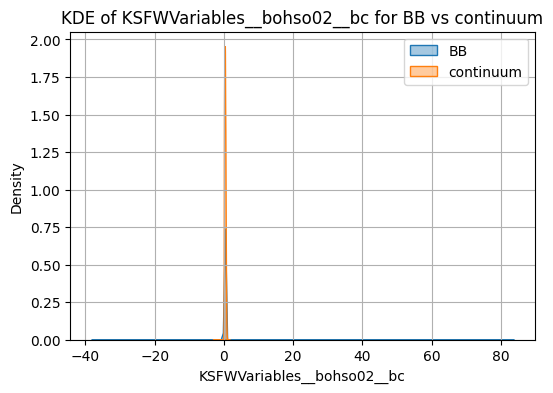

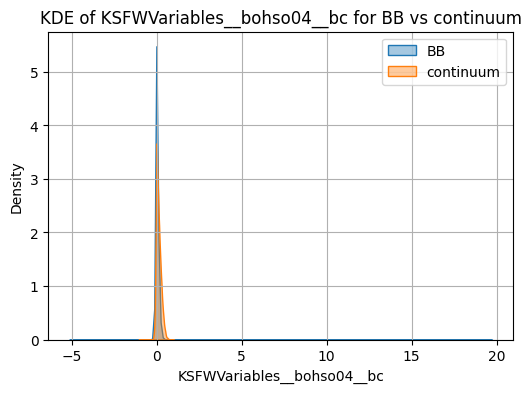

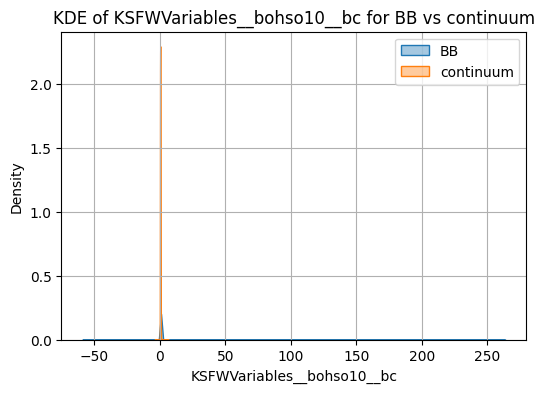

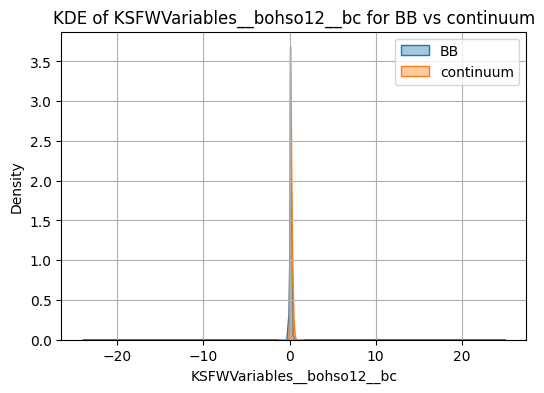

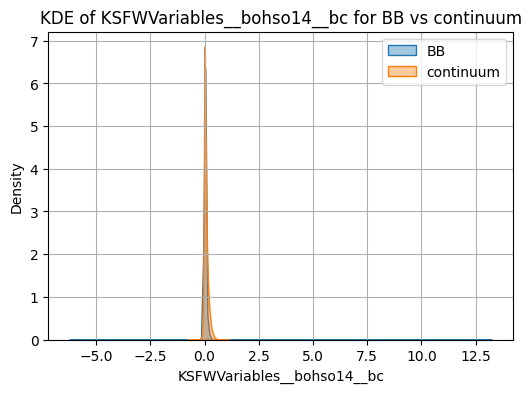

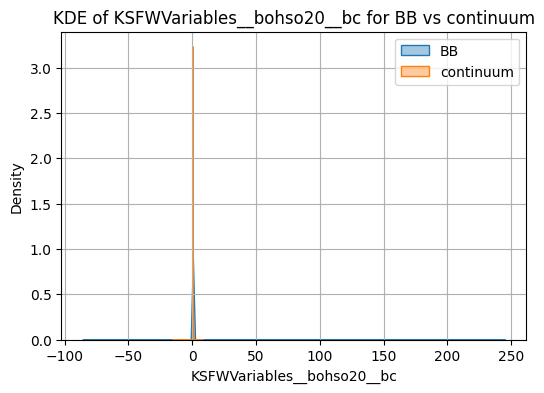

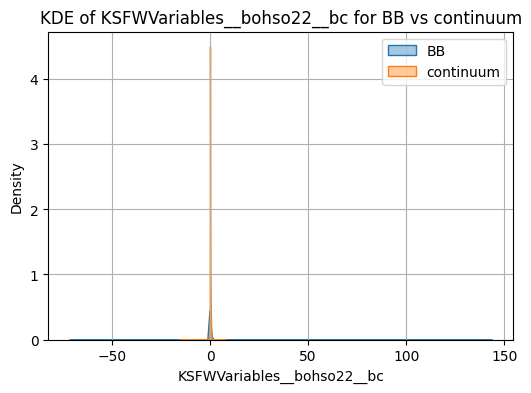

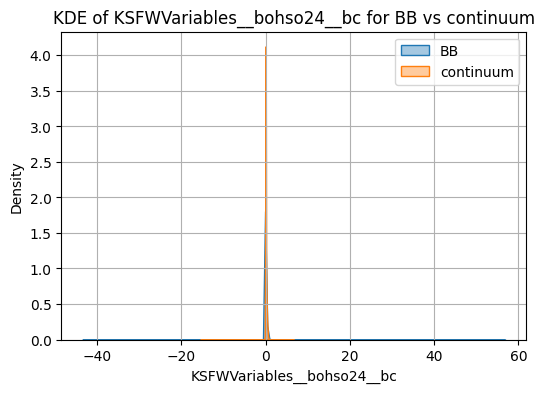

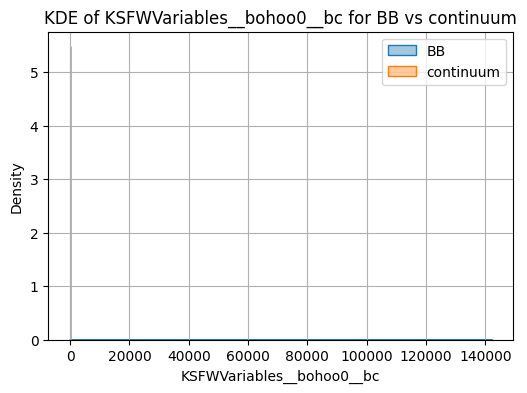

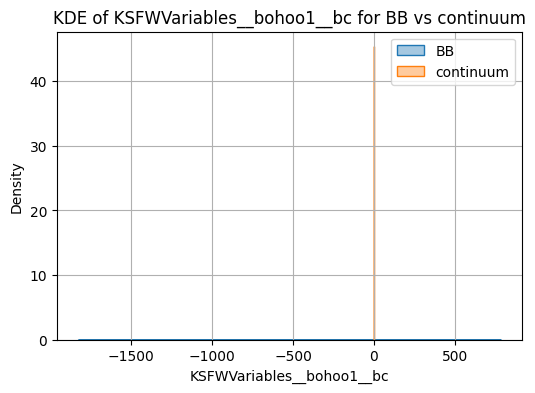

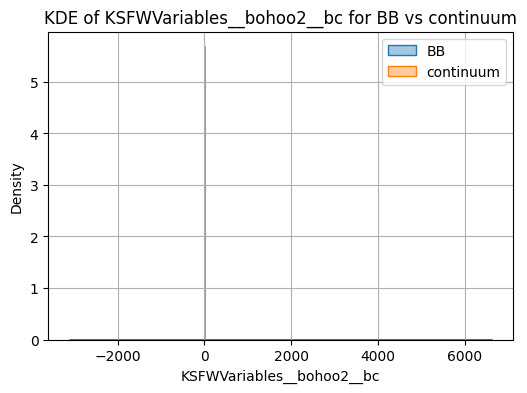

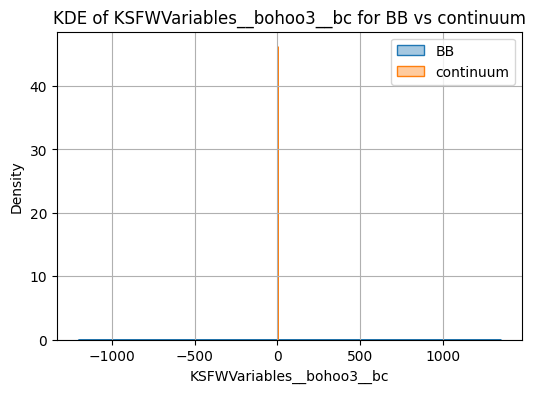

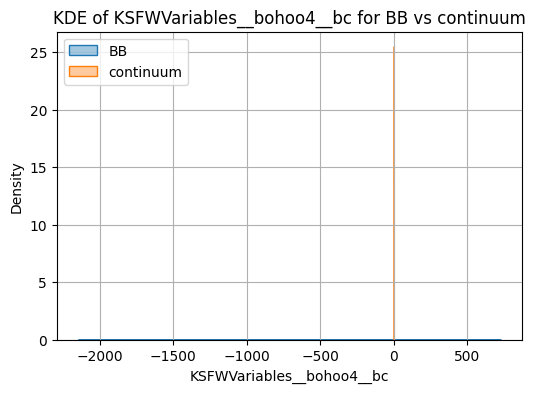

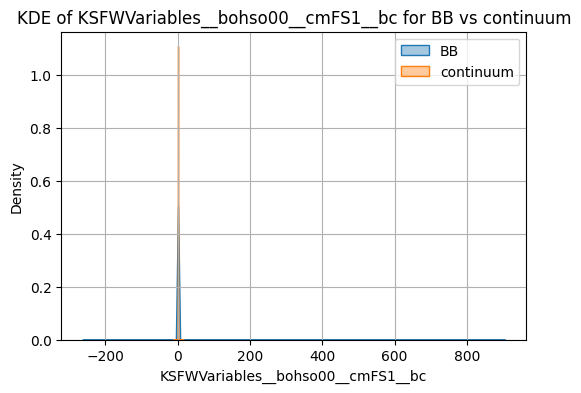

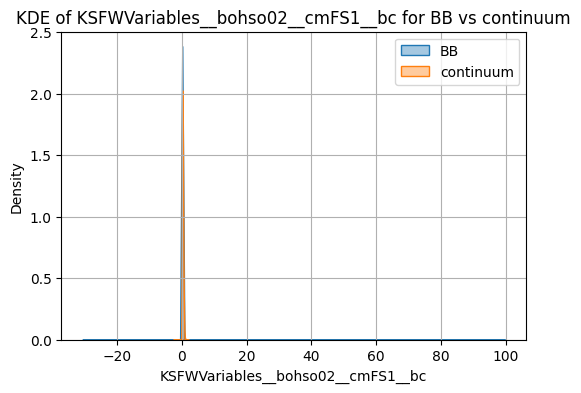

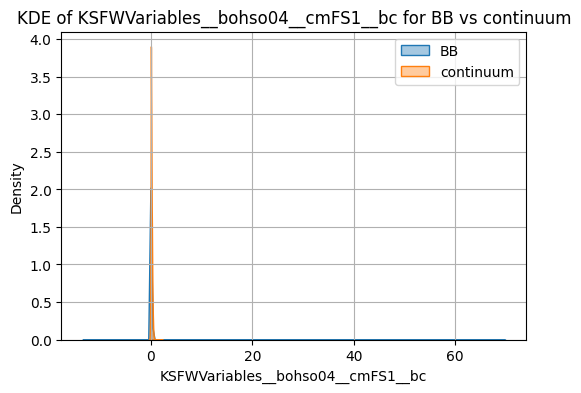

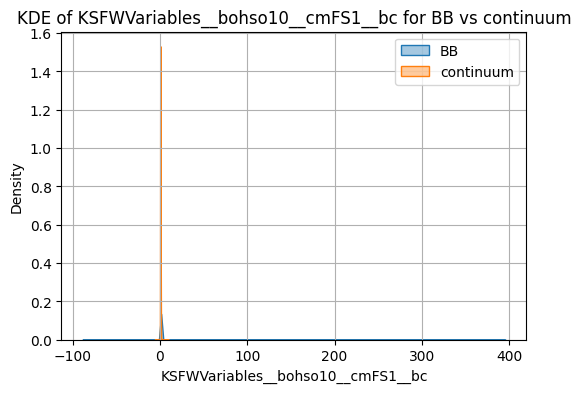

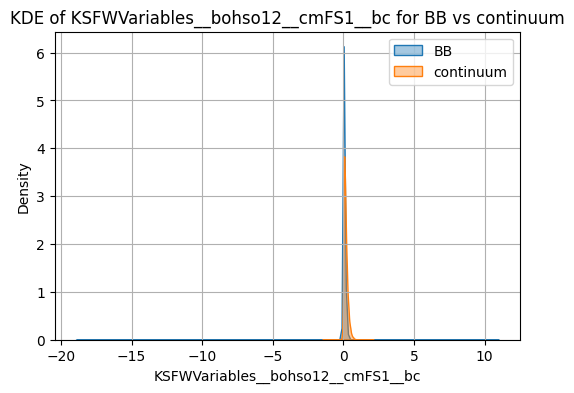

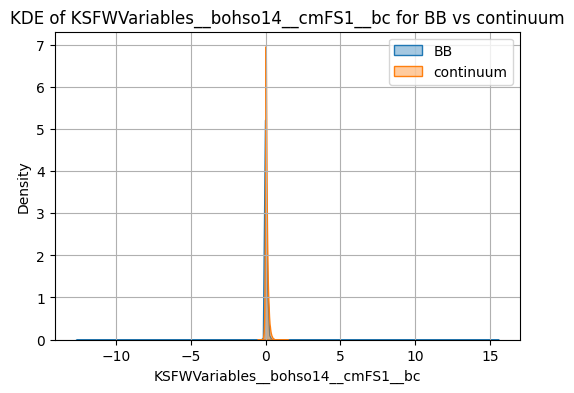

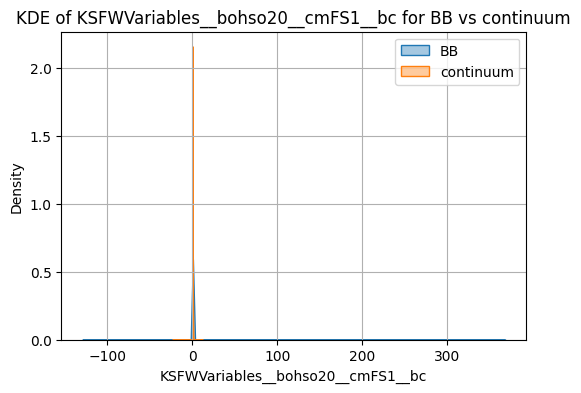

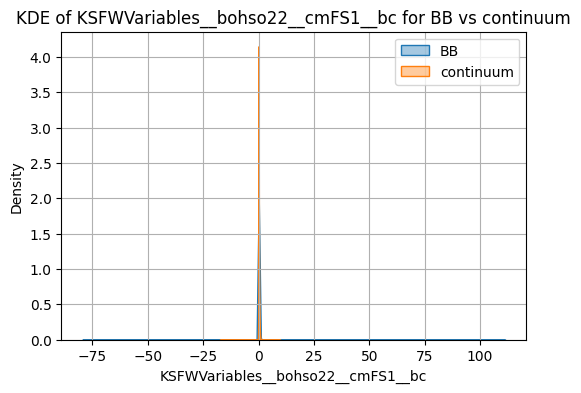

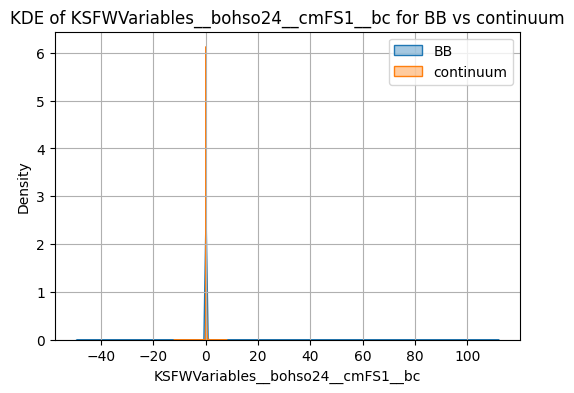

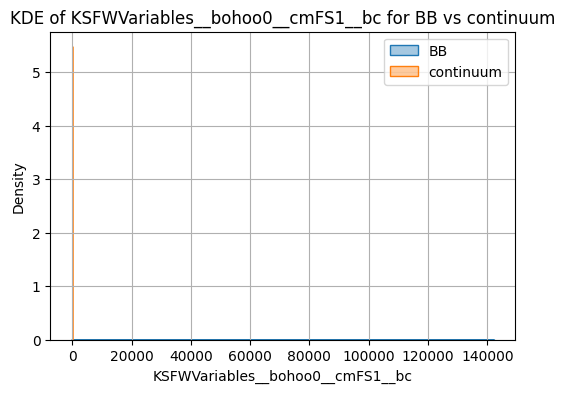

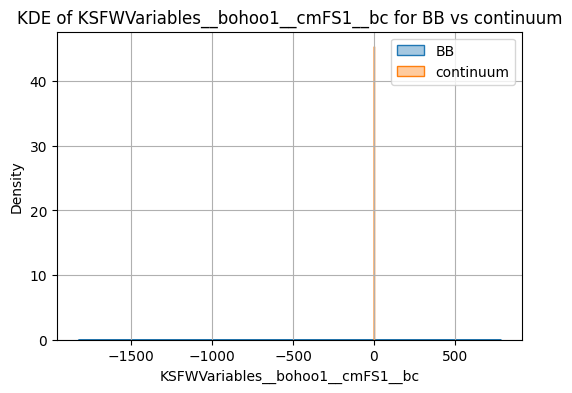

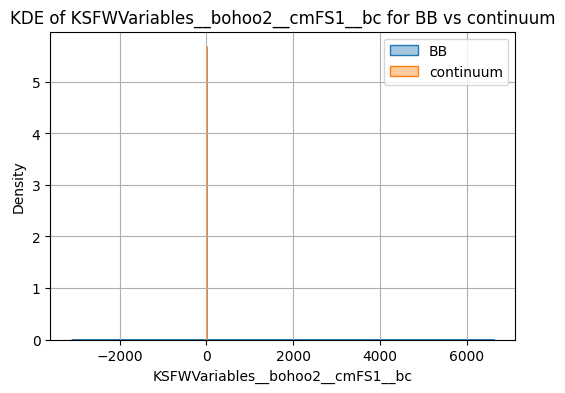

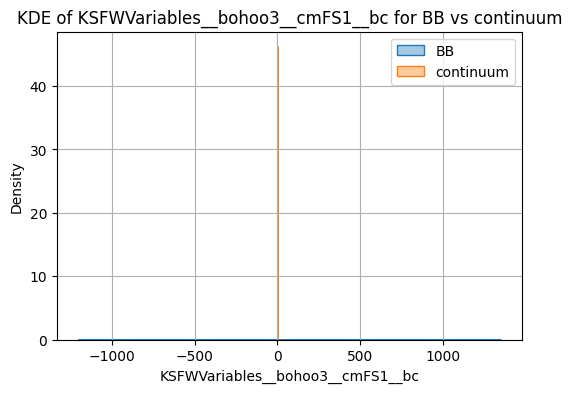

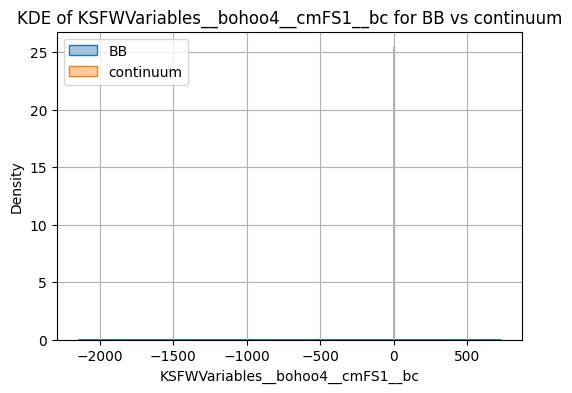

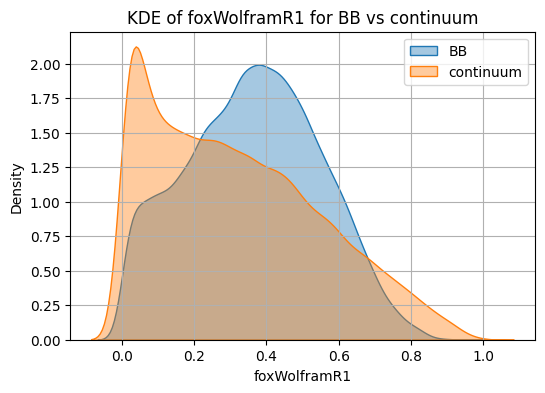

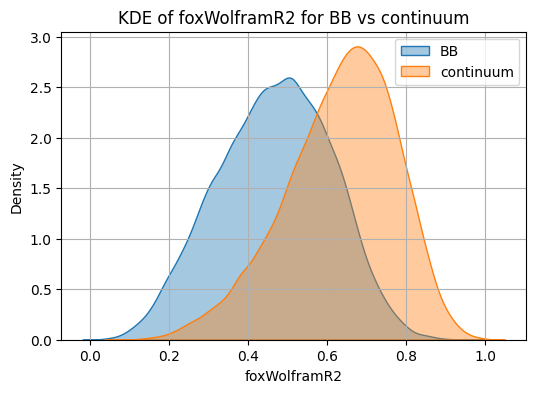

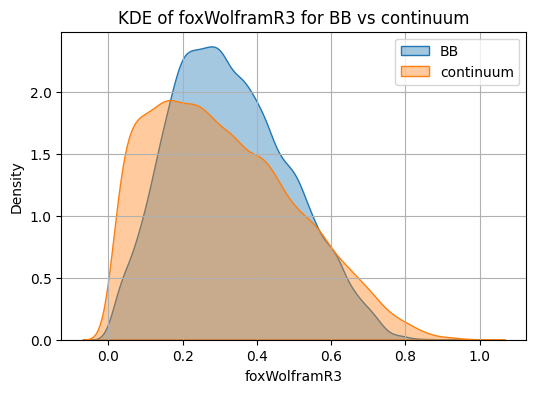

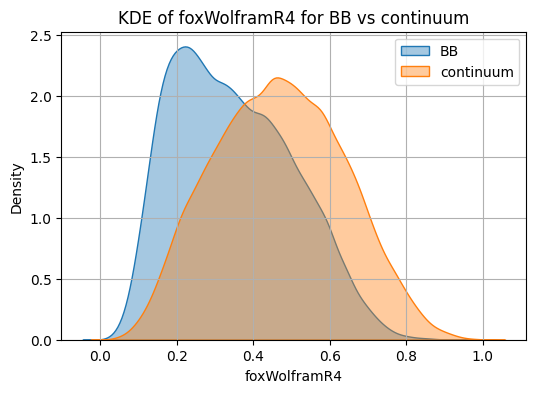

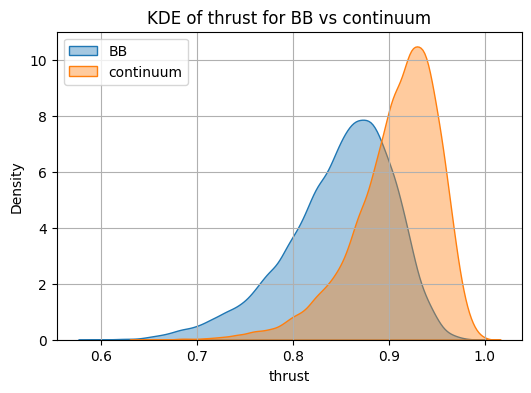

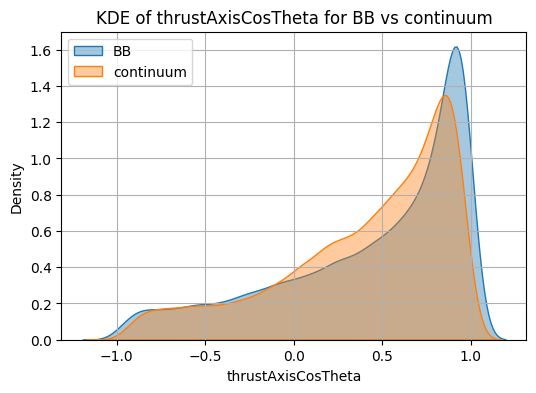

In [ ]:
# -------------------------
# KDE plots for all HEP features (BB vs continuum)
# -------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# List of all your features
features_to_plot = [
    "KSFWVariables__boet__bc","KSFWVariables__bomm2__bc",
    "CleoConeCS__bo1__bc","CleoConeCS__bo2__bc","CleoConeCS__bo3__bc",
    "CleoConeCS__bo4__bc","CleoConeCS__bo5__bc","CleoConeCS__bo6__bc",
    "CleoConeCS__bo7__bc","CleoConeCS__bo8__bc","CleoConeCS__bo9__bc",
    "CleoConeCS__bo1__cmROE__bc","CleoConeCS__bo2__cmROE__bc",
    "CleoConeCS__bo3__cmROE__bc","CleoConeCS__bo4__cmROE__bc",
    "CleoConeCS__bo5__cmROE__bc","CleoConeCS__bo6__cmROE__bc",
    "CleoConeCS__bo7__cmROE__bc","CleoConeCS__bo8__cmROE__bc",
    "CleoConeCS__bo9__cmROE__bc","KSFWVariables__bohso00__bc",
    "KSFWVariables__bohso02__bc","KSFWVariables__bohso04__bc",
    "KSFWVariables__bohso10__bc","KSFWVariables__bohso12__bc",
    "KSFWVariables__bohso14__bc","KSFWVariables__bohso20__bc",
    "KSFWVariables__bohso22__bc","KSFWVariables__bohso24__bc",
    "KSFWVariables__bohoo0__bc","KSFWVariables__bohoo1__bc",
    "KSFWVariables__bohoo2__bc","KSFWVariables__bohoo3__bc",
    "KSFWVariables__bohoo4__bc","KSFWVariables__bohso00__cmFS1__bc",
    "KSFWVariables__bohso02__cmFS1__bc","KSFWVariables__bohso04__cmFS1__bc",
    "KSFWVariables__bohso10__cmFS1__bc","KSFWVariables__bohso12__cmFS1__bc",
    "KSFWVariables__bohso14__cmFS1__bc","KSFWVariables__bohso20__cmFS1__bc",
    "KSFWVariables__bohso22__cmFS1__bc","KSFWVariables__bohso24__cmFS1__bc",
    "KSFWVariables__bohoo0__cmFS1__bc","KSFWVariables__bohoo1__cmFS1__bc",
    "KSFWVariables__bohoo2__cmFS1__bc","KSFWVariables__bohoo3__cmFS1__bc",
    "KSFWVariables__bohoo4__cmFS1__bc","foxWolframR1","foxWolframR2",
    "foxWolframR3","foxWolframR4","thrust","thrustAxisCosTheta"
]

# Loop through all features
for feature in features_to_plot:
    if feature not in df.columns:
        print(f"Warning: {feature} not found in dataframe. Skipping...")
        continue

    plt.figure(figsize=(6,4))

    # KDE for BB
    bb_data = df[df["binary_label"]=="BB"][feature].dropna()
    sns.kdeplot(bb_data, label="BB", color="C0", fill=True, alpha=0.4)

    # KDE for continuum
    cont_data = df[df["binary_label"]=="continuum"][feature].dropna()
    sns.kdeplot(cont_data, label="continuum", color="C1", fill=True, alpha=0.4)

    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.title(f"KDE of {feature} for BB vs continuum")
    plt.legend()
    plt.grid(True)
    plt.show()


correlation

In [ ]:
# -------------------------
# Compute BB-continuum overlap (threshold 98%)
# -------------------------
import numpy as np
from scipy.stats import gaussian_kde

low_overlap_features = []

for feature in features_to_plot:
    if feature not in df.columns:
        continue

    bb_data = df[df["binary_label"]=="BB"][feature].dropna()
    cont_data = df[df["binary_label"]=="continuum"][feature].dropna()

    # Skip if not enough data
    if len(bb_data) < 2 or len(cont_data) < 2:
        continue

    # KDE objects
    bb_kde = gaussian_kde(bb_data)
    cont_kde = gaussian_kde(cont_data)

    # Common x-grid
    x_min = min(bb_data.min(), cont_data.min())
    x_max = max(bb_data.max(), cont_data.max())
    x_grid = np.linspace(x_min, x_max, 1000)

    # Evaluate KDE on the same grid
    bb_vals = bb_kde(x_grid)
    cont_vals = cont_kde(x_grid)

    # Compute overlap
    overlap_area = np.trapz(np.minimum(bb_vals, cont_vals), x_grid)  # can also use np.trapezoid
    if overlap_area < 0.98:  # changed threshold to 98%
        low_overlap_features.append((feature, overlap_area))

# Sort by overlap (lowest first)
low_overlap_features = sorted(low_overlap_features, key=lambda x: x[1])

print("Features with BB-continuum overlap < 98%:")
for f, overlap in low_overlap_features:
    print(f"{f}: {overlap:.3f}")


/tmp/ipython-input-3980610827.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  overlap_area = np.trapz(np.minimum(bb_vals, cont_vals), x_grid)  # can also use np.trapezoid


Features with BB-continuum overlap < 98%:
KSFWVariables__bohoo1__bc: 0.000
KSFWVariables__bohoo2__bc: 0.000
KSFWVariables__bohoo3__bc: 0.000
KSFWVariables__bohoo1__cmFS1__bc: 0.000
KSFWVariables__bohoo2__cmFS1__bc: 0.000
KSFWVariables__bohoo3__cmFS1__bc: 0.000
KSFWVariables__bohoo4__bc: 0.005
KSFWVariables__bohoo4__cmFS1__bc: 0.005
KSFWVariables__bohoo0__cmFS1__bc: 0.288
KSFWVariables__bohoo0__bc: 0.288
CleoConeCS__bo1__cmROE__bc: 0.519
thrust: 0.535
foxWolframR2: 0.562
KSFWVariables__bohso00__cmFS1__bc: 0.594
KSFWVariables__bohso00__bc: 0.594
KSFWVariables__bohso20__cmFS1__bc: 0.598
KSFWVariables__bohso20__bc: 0.598
CleoConeCS__bo1__bc: 0.608
CleoConeCS__bo2__cmROE__bc: 0.610
CleoConeCS__bo9__cmROE__bc: 0.617
KSFWVariables__bohso02__bc: 0.625
CleoConeCS__bo9__bc: 0.625
CleoConeCS__bo8__cmROE__bc: 0.627
CleoConeCS__bo8__bc: 0.647
KSFWVariables__bohso12__bc: 0.650
KSFWVariables__bohso22__bc: 0.653
KSFWVariables__bohso12__cmFS1__bc: 0.653
KSFWVariables__bohso02__cmFS1__bc: 0.657
CleoCone

confusion_matrix of respect to above parameters

In [ ]:
# -------------------------
# Binary classification using low-overlap features
# -------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Extract the low-overlap features
selected_features = [f for f, _ in low_overlap_features]

print(f"Using {len(selected_features)} features for classification:\n", selected_features)

# Prepare data
X = df[selected_features].fillna(0).values
y = df["binary_label"].values

# Encode BB = 0, continuum = 1
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Split into train/test
Xtr, Xte, ytr, yte = train_test_split(X, y_enc, test_size=0.25, stratify=y_enc, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=150, max_depth=7, random_state=42, n_jobs=-1)
rf.fit(Xtr, ytr)

# Predictions
ypred = rf.predict(Xte)

# Confusion Matrix
cm = confusion_matrix(yte, ypred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(yte, ypred, target_names=le.classes_))


Using 54 features for classification:
 ['KSFWVariables__bohoo1__bc', 'KSFWVariables__bohoo2__bc', 'KSFWVariables__bohoo3__bc', 'KSFWVariables__bohoo1__cmFS1__bc', 'KSFWVariables__bohoo2__cmFS1__bc', 'KSFWVariables__bohoo3__cmFS1__bc', 'KSFWVariables__bohoo4__bc', 'KSFWVariables__bohoo4__cmFS1__bc', 'KSFWVariables__bohoo0__cmFS1__bc', 'KSFWVariables__bohoo0__bc', 'CleoConeCS__bo1__cmROE__bc', 'thrust', 'foxWolframR2', 'KSFWVariables__bohso00__cmFS1__bc', 'KSFWVariables__bohso00__bc', 'KSFWVariables__bohso20__cmFS1__bc', 'KSFWVariables__bohso20__bc', 'CleoConeCS__bo1__bc', 'CleoConeCS__bo2__cmROE__bc', 'CleoConeCS__bo9__cmROE__bc', 'KSFWVariables__bohso02__bc', 'CleoConeCS__bo9__bc', 'CleoConeCS__bo8__cmROE__bc', 'CleoConeCS__bo8__bc', 'KSFWVariables__bohso12__bc', 'KSFWVariables__bohso22__bc', 'KSFWVariables__bohso12__cmFS1__bc', 'KSFWVariables__bohso02__cmFS1__bc', 'CleoConeCS__bo7__cmROE__bc', 'CleoConeCS__bo2__bc', 'KSFWVariables__bohso24__cmFS1__bc', 'CleoConeCS__bo7__bc', 'KSFWVari

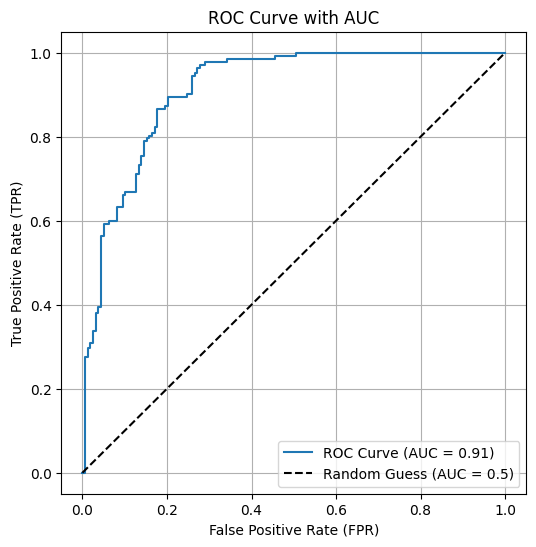

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

# -------------------------
# 1. Generate synthetic dataset
# -------------------------
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2,
                           n_informative=5, random_state=42)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# -------------------------
# 2. Train a classifier
# -------------------------
model = LogisticRegression()
model.fit(X_train, y_train)

# Get predicted probabilities (for ROC we need probabilities, not labels)
y_probs = model.predict_proba(X_test)[:, 1]

# -------------------------
# 3. Compute ROC curve
# -------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# -------------------------
# 4. Plot ROC curve
# -------------------------
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve with AUC')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# --------------------------
# ROC–AUC Comparison
# --------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score



plt.figure(figsize=(6, 5))

# Logistic Regression
y_prob_lr = lr.predict_proba(Xte_red_s)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(yte, y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={auc_lr:.3f})")

# CatBoost
y_prob_cat = cat_model.predict_proba(Xte_red_s)[:, 1]
fpr_cat, tpr_cat, _ = roc_curve(yte, y_prob_cat)
auc_cat = auc(fpr_cat, tpr_cat)
plt.plot(fpr_cat, tpr_cat, label=f"CatBoost (AUC={auc_cat:.3f})")

# XGBoost
y_prob_xgb = xgb_model.predict_proba(Xte_red_s)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(yte, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc_xgb:.3f})")

# LightGBM
y_prob_lgb = lgb_model.predict_proba(Xte_red_s)[:, 1]
fpr_lgb, tpr_lgb, _ = roc_curve(yte, y_prob_lgb)
auc_lgb = auc(fpr_lgb, tpr_lgb)
plt.plot(fpr_lgb, tpr_lgb, label=f"LightGBM (AUC={auc_lgb:.3f})")

# Plot settings
plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Binary Classification Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'lr' is not defined

<Figure size 600x500 with 0 Axes>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# 1. Load your dataset
# --------------------------
df = pd.read_csv("hep.csv")

# Check the column names
print("Columns in the dataset:\n", df.columns)

# --------------------------
# 2. Identify your target variable
# --------------------------
# Example: if your target column is named 'label' or 'target' or 'binary_label'
target_col = 'binary_label'  # change this if your column has a different name

# --------------------------
# 3. Select only numeric feature columns
# --------------------------
features = df.select_dtypes(include=['float64', 'int64']).drop(columns=[target_col], errors='ignore')
print("\nNumeric feature columns:\n", features.columns)

# --------------------------
# 4. Compute correlation matrix
# --------------------------
corr_matrix = features.corr()

# --------------------------
# 5. Add correlation with target
# --------------------------
corr_with_target = df.corr(numeric_only=True)[target_col].sort_values(ascending=False)
print("\nCorrelation of each feature with target:\n", corr_with_target)

# --------------------------
# 6. Plot heatmap
# --------------------------
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix (Excluding Target)")
plt.show()

# --------------------------
# 7. Plot correlation with target as bar chart
# --------------------------
corr_with_target.drop(target_col, errors='ignore').plot(kind='bar', figsize=(10,5))
plt.title("Correlation of Features with Target")
plt.ylabel("Correlation coefficient")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'hep.csv'